In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy.fft as nf
from scipy import stats
import seaborn as sns

In [2]:
def filter_data(df):
    b, a = signal.butter(3, 0.15, btype='lowpass', analog=False)
    low_passed = signal.filtfilt(b, a, df['aT (m/s^2)'])
    #peaks,_ = signal.find_peaks(df['aT (m/s^2)'])
    #plt.plot(df['time'],low_passed)
    #plt.plot(df['time'],df['aT (m/s^2)'])
    return low_passed


def calculate_vel(df):
    temp=df.shift(periods=-1)
    diff_df=abs(df-temp)
    temp_df=diff_df.shift(periods=1)
    temp_df.iloc[0]=df.iloc[0]
    df['diff_time']=temp_df['time']
    df['velocity']=df['diff_time']*df['aT (m/s^2)']
    return df
    

def calculate_delta_position(df):
    df['position']=df['diff_time']*df['velocity']
    return df

def calculate_total_position(df):
    df2=df
    df2=df2.cumsum(axis=0)
    df['total_position']=df2['position']
    return df


def transform_df(df):
    #using the above function to form the final df we want
    df['aT (m/s^2)']=filter_data(df)
    df=calculate_vel(df)
    df=calculate_delta_position(df)
    df=calculate_total_position(df)
    df = df[0:16000]

    return df


def get_model(df):
    X=np.stack([df['time']],axis=1)
    X_with=np.concatenate([np.ones(X.shape),X],axis=1)
    model=LinearRegression(fit_intercept=False)
    model.fit(X_with,df['total_position'])
    return model
    

def get_model_train_set(df):
    X=np.stack([df['time']],axis=1)
    X_with=np.concatenate([np.ones(X.shape),X],axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_with,df['total_position'])
    return X_train, X_valid, y_train, y_valid


def get_interval(df):
    interval_1=df[df['time']<=40.0]
    data_1=interval_1['position'].sum()
    interval_2=df[(df['time']>40.0) & (df['time']<=80.0)]
    data_2=interval_2['position'].sum()
    interval_3=df[(df['time']>80.0) & (df['time']<=120.0)]
    data_3=interval_3['position'].sum()
    interval_4=df[df['time']>120.0]
    data_4=interval_4['position'].sum()
    pos_data=np.array([data_1,data_2,data_3,data_4])
    return pos_data


def get_averages(arr):
    total=np.array([0,0,0,0])
    for file in range(0,len(arr)):
        gender=pd.read_csv(arr[file])
        gender=transform_df(gender)
        gender_data=get_interval(gender)
        total=total+gender_data
        #print('\n',total)
    total=total/len(arr)
    return total

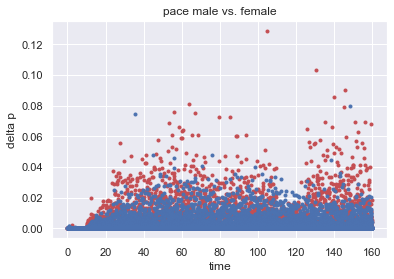

In [3]:
male_files=['male_1','male_2','male_3','male_4','male_5']
female_files=['female_1','female_2','female_3','female_4','female_5']

male=pd.read_csv('male_2')
male=transform_df(male)
female=pd.read_csv('female_2')
female=transform_df(female)
sns.set()
plt.title('pace male vs. female')
plt.xlabel('time')
plt.ylabel('delta p')
plt.plot(male['time'],male['position'],'r.')
plt.plot(female['time'],female['position'],'b.')
#sns.distplot(male['time'])
#sns.jointplot(x="time",y="position",data=male,kind='kde')
#sns.jointplot(x='time',y='position',data=female,kind='kde')

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


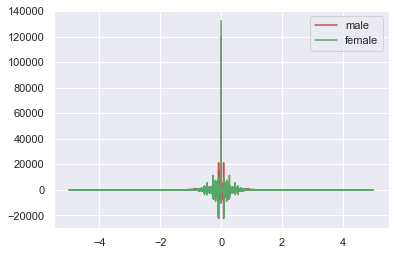

In [8]:
#see the freq different between one male and female
#reference: https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft
fourier = np.fft.fft(male['aT (m/s^2)'])
n = male['aT (m/s^2)'].size
timestep = 0.1
freq = np.fft.fftfreq(n, d=timestep)

fourier2=np.fft.fft(female['aT (m/s^2)'])
n2 = female['aT (m/s^2)'].size
freq2=np.fft.fftfreq(n2,d=timestep)

plt.plot(freq,fourier,'r-')
plt.plot(freq2,fourier2,'g-')
plt.legend(['male','female'])

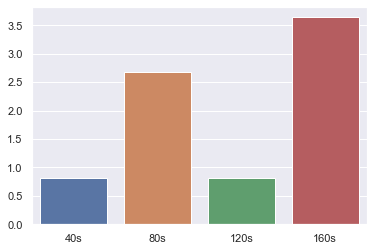

In [5]:
#want the data every 40s to see the change of pace
male_data=get_interval(male)
female_data=get_interval(female)
diff_data=male_data-female_data
time=np.array(['40s','80s','120s','160s'])
diff_df=male
#diff_df['residuals']=abs(male['position']-female['position'])
sns.barplot(x=time,y=diff_data)
#conclusion:

[3.22181541 5.28461487 4.73710147 5.22988668]
[2.87164122 5.26194104 5.19094932 4.76804236]


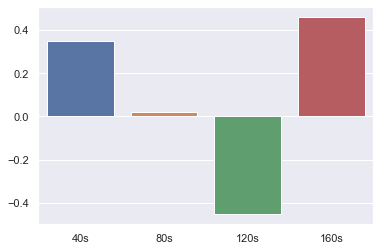

In [6]:
#want the data every 40s to see for that amount of times who walk more position
whole_male_data=get_averages(male_files)
print(whole_male_data)
whole_female_data=get_averages(female_files)
print(whole_female_data)
diff_data=whole_male_data-whole_female_data
#time=np.array(['40s','80s','120s','160s'])
#diff_df=male
sns.set()
sns.barplot(x=time,y=diff_data)
#conclusion: 

In [7]:
male

,time,ax (m/s^2),ay (m/s^2),az (m/s^2),aT (m/s^2),diff_time,velocity,position,total_position
0,0.000804,0.2501,-0.1210,0.1829,0.333892,0.000804,0.000268,2.158334e-07,2.158334e-07
1,0.008997,-0.2162,-0.2000,-0.3301,0.776891,0.008193,0.006365,5.214897e-05,5.236481e-05
2,0.019056,-1.9461,-0.6025,-1.5788,1.141640,0.010059,0.011484,1.155151e-04,1.678799e-04
3,0.029932,-2.8597,-0.5242,-0.6504,1.369339,0.010876,0.014893,1.619755e-04,3.298555e-04
4,0.039001,2.3130,-0.1716,0.1736,1.434146,0.009069,0.013006,1.179539e-04,4.478094e-04
...,...,...,...,...,...,...,...,...,...
15995,159.949168,-3.5151,0.1318,-1.0751,1.552919,0.005582,0.008668,4.838696e-05,3.160856e+01
15996,159.959172,0.8113,0.1120,-0.8214,1.746887,0.010004,0.017476,1.748284e-04,3.160873e+01
15997,159.969155,3.5299,-0.0754,0.0362,1.878731,0.009983,0.018755,1.872349e-04,3.160892e+01
15998,159.979640,1.7079,-0.0165,0.3616,1.949122,0.010485,0.020437,2.142771e-04,3.160913e+01
